Sometimes I find myself reading a paper or trying to design a model or formulate an algorithm at work, when I suddenly stop short, stare at some primitive operation, and realise that I have no idea how it's done. This happended recently with the realization that I didn't know how to sampling non-uniform random variates from a number of basic probability distributions. I started pulling at threads and digging into papers, and ended up reading a good deal of Art Owen's and Luc Devroye's excellent books in an effort to fill in the gaps. This notebook has some details of some of the interesting things I've been learning that I wanted to explore more thoroughly, starting with the ratio-of-uniforms method for sampling.

In [1]:
# gimme gimme gimme
import numpy as np
import scipy.optimize as opt
import scipy.special as spf
import matplotlib.pyplot as plt

# abracadabra
%matplotlib inline
plt.style.use('ggplot')

# Ratio of Unifoms for Continuous Random Variables

The ratio of uniforms method works by uniformly sampling a random point in a 2D region of the plane, and then calculating the ratio of the coordinates to get a random variate with the desired distribution.

We'll start with continuous random variables, and we'll assume that the target distribution is generally nice in all appropriate ways and has density function $f(x)$.

## Derivation

## Here are the steps...

### Sample a 2D point

Draw a sample $(u,v)$ uniformly from the region $C = \left\{ (u,v) : 0 \leq u \leq \sqrt{f(v/u)} \right\}$. For now, let's just assume that we can do this, without worrying about how. The density function is $f_{U,V}(u,v) = \frac{1}{K}$ where $K$ is the area of $C$, which of course we don't know. Let's not worry about that either for now.

### Transform

Being a bit sloppy with notation, define the transformation $(X, Y) = (V/U, U)$. The jacobian of this transformation is as follows.

\begin{equation}
J = \det \begin{bmatrix} \frac{\partial x}{\partial u} & \frac{\partial x}{\partial v} \\ \frac{\partial y}{\partial u} & \frac{\partial y}{\partial v} \end{bmatrix} = \det \begin{bmatrix} -\frac{v}{u^2} & \frac{1}{u} \\ 1 & 0 \end{bmatrix} = \frac{1}{u} = \frac{1}{y}
\end{equation}

Now we can work out the density in terms of $X, Y$, using the standard transformation.

\begin{equation}
p_{X, Y}(x, y) = \frac{1}{J} p_{U, V}(u, v) = \frac{y}{K}
\end{equation}

The support set becomes $C = \left\{ (x,y) : 0 \leq y \leq \sqrt{f(x)} \right\}$

### Marginalise

Now, marginalise $Y$.

\begin{align}
p_X(x) &= \int_C p_{X, Y}(x, y) dy \\
       &= \int_0^{\sqrt{f(x)}} \frac{y}{K} dy \\
       &= \frac{1}{K} \left[\frac{y^2}{2}\right]_0^{\sqrt{f(x)}} \\
       &= \frac{1}{2 \: K} \:f(x)
\end{align}

Neat. Finally, since $\int p_X(x) dx = 1$, we _must_ have had $K = \frac{1}{2}$ all along. With this information, we end up with exactly what we wanted.

$$
p_X(x) = f(x)
$$

## Pictures!

The procedure is the same for _any_ density function, just with a different region $C$ in the $(U, V)$, space. Let's take a look at these regions for some standard distributions. We could find points on the boundary by setting $u$ and solving for $v$ using the following.

\begin{align}
u &= \sqrt{f(v/u)} \\
\Rightarrow u^2 &= f(v/u)
\end{align}

I tried that. It doesn't work very well, because where the boundary becomes near-vertical, the solver throws all the toys out of the pram. Instead, let's use a grid of $\theta$, the angle from the $u$-axis. Then $v/u=\tan\theta$, so we can calculate $u$ and $v$ using easily.

\begin{align}
u &= \sqrt{f(v/u)} \\
v &= u\tan\theta
\end{align}

In [2]:
def draw_uv_region(f):
    
    # Make a grid for theta
    nearly_pi_on_two = np.pi - 0.01
    th_range = np.arange(-nearly_pi_on_two, nearly_pi_on_two, 0.001)
    
    # Calculate u and v
    v_over_u_range = [np.tan(th) for th in th_range]
    u_range = [np.sqrt(f(v_over_u)) for v_over_u in v_over_u_range]
    v_range = [u * v_over_u for (u, v_over_u) in zip(u_range, v_over_u_range)]
    
    # Plot it
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(u_range, v_range, 'r')
    
    plt.show()

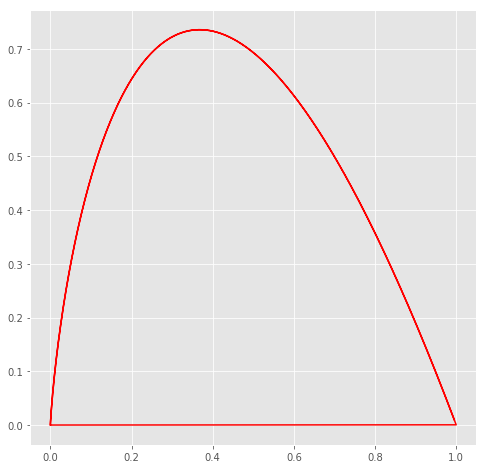

In [3]:
# Exponential
draw_uv_region(lambda x: np.exp(-x) if x >= 0 else 0)

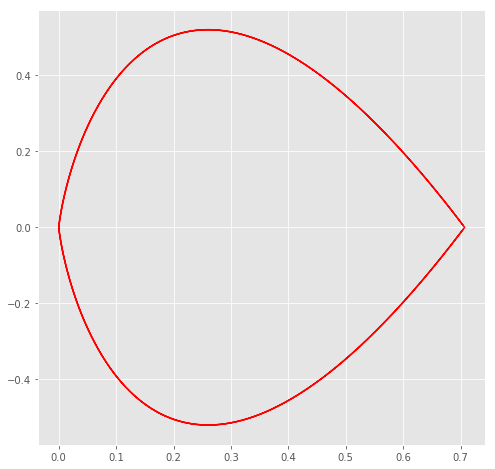

In [4]:
# Double Exponential
draw_uv_region(lambda x: np.exp(-np.abs(x)) / 2)

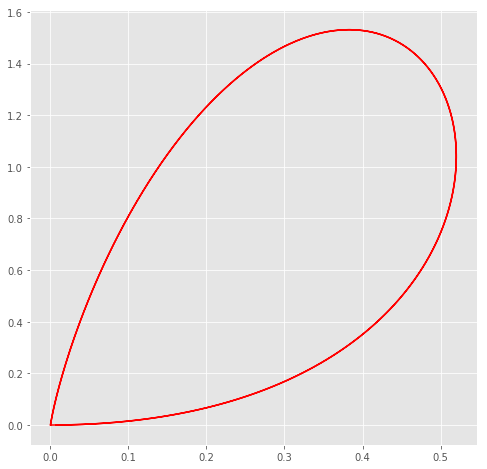

In [5]:
# Gamma
a = 3
draw_uv_region(lambda x: x**(a - 1) * np.exp(-x) / spf.gamma(a) if x >= 0 else 0)

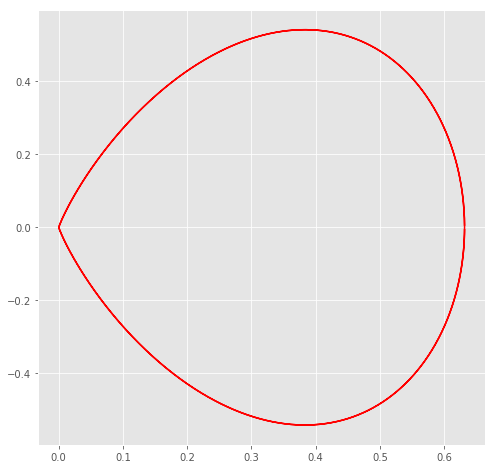

In [6]:
# Standard normal
draw_uv_region(lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi))

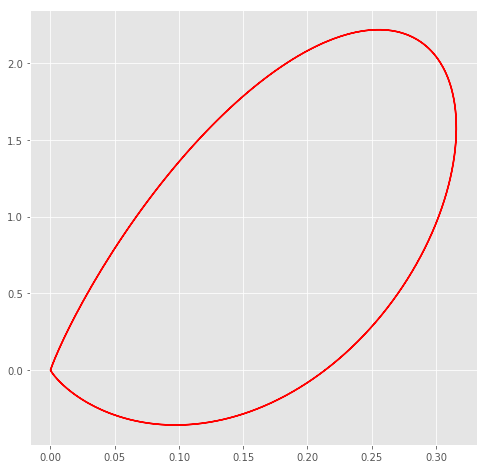

In [7]:
# Non-standard normal
m = 5
s = 16
draw_uv_region(lambda x: np.exp(-(x - m)**2 / (2 * s)) / np.sqrt(2 * np.pi * s))

Well that was pleasing. And it's a powerful principle - any density can be sampled just by sampling uniformly from right shape and applying the transformation. But of course, there's no free lunch. Sampling uniformly from the 2D region isn't much easier. We can do this generically using rejection sampling: Draw a box around the shape, sample uniformly from it, and reject those that are not inside. The hard bit is now working out how large the bounding box needs to be.